The goal of this notebook is to explore and define how to assess the type of forest cover located within a polygon (typically a clear cut polygon), based on the BDFORET V2 dataset

In [56]:
import ee
import geemap
import geopandas as gpd
import matplotlib
import numpy as np
import pandas as pd
import rasterio
import rioxarray

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
from rasterio.plot import show
from tqdm import tqdm

In [46]:
plot_palette = {
    "Sans couvert arboré": "#A0522D",
    "Feuillus": "#228B22",
    "Conifères": "#006400",
    "Mixte": "#808000",
    "Peupleraie": "#8FBC8F",
    "Lande": "#9ACD32",
    "Formation herbacée": "#98FB98",
}

# Pure polygon-based assessment: two-stage spatial join (first departments then BDFORET polygons)

The method explored here consists in a two-step spatial join approach in order to load a limited amount of BDFORET polygons (corresponding to the department(s) that contain the target polygon), and then compute forest cover type ratios by intersecting these BDFORET polygons with the target polygon.

The method consists in the following steps:
- identify which department(s) polygon(s) intersect with the target polygon
- load the BDFORET polygons for the identified department(s)
- identify which BDFORET polygons intersect with the target polygon
- compute forest cover type ratios within the target polygon

Note: in order to work easily with the BDFORET dataset, the latter has been pre-processed in order to:
- simplify file access
- simplify the polygon categories into a single, 7-class feature

The source BDFORET data used by this section is stored as a single, flat folder containing one shapefile (.shp) and its associated metadata (.cpg, .dbf, .prj, .shx) per department.

Moreover, the original data were altered in order to only contain a simplified version of the "TFV_G11" attribute (which has 11 categories) named "TFV_SIMPLE" (which has 7 categories). Here is the mapping between the TFV_G11 AND TFV_SIMPLE attributes:
- "Forêt fermée sans couvert arboré": "Sans couvert arboré"
- "Forêt ouverte sans couvert arboré": "Sans couvert arboré"
- "Forêt fermée feuillus": "Feuillus"
- "Forêt ouverte feuillus": "Feuillus"
- "Forêt fermée conifères": "Conifères"
- "Forêt ouverte conifères": "Conifères"
- "Forêt fermée mixte": "Mixte"
- "Forêt ouverte mixte": "Mixte"
- "Peupleraie": "Peupleraie"
- "Lande": "Lande"
- "Formation herbacée": "Formation herbacée"

The original dataset weights 8.3G while our simplified dataset still weights 7.9G so it requires some space to be stored.

The GeoJSON file that defines the department polygons originates from [France GeoJSON](https://france-geojson.gregoiredavid.fr/). Its weight is negligible.

Finally, the GeoJSON file that stores the clear cut polygons used to test our method was obtained through the older version of the Sufosat V2 aggregation algorithm presented in the 'prepare_sufosat_layer.ipynb' notebook. It runs the filtering/aggregation pipeline and selects cuts with an area > 10 ha observed during the year 2024.

In [8]:
# dest_dirpath = Path("../data/ign/bdforet_2_0/shp_files/")
# for src_path in Path("../data/ign/bdforet_2_0/").glob("BDF*/**/*.prj"):
#     dep_code = src_path.parts[-2][-3:].lstrip("0")
#     if len(dep_code) > 1:
#         dest_path = dest_dirpath / f"{dep_code}.prj"
#     else:
#         dest_path = dest_dirpath / f"0{dep_code}.prj"
#     print(dep_code)
#     print(dest_path)
#     copy(src_path, dest_path)

In [9]:
# for file in Path("../data/ign/bdforet_2_0/shp_files/").glob("*.shp"):
#     dep_code = file.parts[-1].strip(".shp")
#     print(f"DEPARTMENT: {dep_code}")
#     df = gpd.read_file(file)
#     df["TFV_SIMPLE"] = df.TFV_G11.replace(
#         {
#             "Forêt fermée sans couvert arboré": "Sans couvert arboré",
#             "Forêt ouverte sans couvert arboré": "Sans couvert arboré",
#             "Forêt fermée feuillus": "Feuillus",
#             "Forêt ouverte feuillus": "Feuillus",
#             "Forêt fermée conifères": "Conifères",
#             "Forêt ouverte conifères": "Conifères",
#             "Forêt fermée mixte": "Mixte",
#             "Forêt ouverte mixte": "Mixte",
#             "Peupleraie": "Peupleraie",
#             "Lande": "Lande",
#             "Formation herbacée": "Formation herbacée",
#         }
#     ).astype("category")
#     df = df.drop(columns=["ID", "CODE_TFV", "TFV", "TFV_G11", "ESSENCE"])
#     if len(dep_code) > 1:
#         dest_path = f"../data/ign/bdforet_2_0/tfv_simple/{dep_code}.shp"
#     else:
#         dest_path = f"../data/ign/bdforet_2_0/tfv_simple/0{dep_code}.shp"
#     print(dest_path)
#     df.to_file(dest_path)

Matching a clear clut to the containing department(s)

In [10]:
gdf_cuts = gpd.read_file("../data/geometries/gdf_sample_clear_cuts.geojson")
gdf_departments = gpd.read_file("../data/geometries/all_departments.geojson").to_crs(
    "EPSG:2154"
)

We observe that most clear cuts (multi)polygons are contained within a single department, while some are outside french territory and one is overlapping two departments (index 3, located between Landes and Gironde)

In [11]:
test_dep_sjoin = gdf_cuts.sjoin(gdf_departments, how="left", predicate="intersects")
test_dep_sjoin

,clear_cut_group,date_min,date_max,days_delta,clear_cut_group_size,area_ha,geometry,index_right,code,nom
0,40063,2024-06-28,2024-08-03,36,28,10.027192,"POLYGON ((463214.121 6341961.718, 463185.363 6...",10.0,47,Lot-et-Garonne
1,48216,2024-06-21,2024-08-03,43,87,10.500394,"POLYGON ((367544.441 6351902.694, 367525.299 6...",7.0,40,Landes
2,30485,2024-06-15,2024-08-02,48,33,10.949711,"POLYGON ((490353.961 6445604.284, 490344.532 6...",27.0,24,Dordogne
3,39066,2024-06-03,2024-08-02,60,13,11.162990,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",7.0,40,Landes
3,39066,2024-06-03,2024-08-02,60,13,11.162990,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",54.0,33,Gironde
4,11933,2024-05-02,2024-05-14,12,16,11.277782,"POLYGON ((1004010.877 6679036.791, 1004010.877...",NaN,NaN,NaN
5,20917,2024-06-15,2024-08-03,49,119,11.643299,"MULTIPOLYGON (((462466.889 6599030.176, 462466...",94.0,79,Deux-Sèvres
6,9622,2024-03-08,2024-05-07,60,51,12.254396,"MULTIPOLYGON (((1058292.53 6502565.819, 105827...",NaN,NaN,NaN
7,50028,2024-06-15,2024-08-02,48,80,12.267579,"POLYGON ((348349.487 6303934.768, 348349.487 6...",7.0,40,Landes
8,41240,2024-06-27,2024-08-03,37,78,12.596832,"POLYGON ((432921.421 6431708.372, 432920.989 6...",54.0,33,Gironde


## Case 0: a single department contains the clear cut polygon

In [12]:
gdf_cuts = gpd.read_file("../data/geometries/gdf_sample_clear_cuts.geojson")
gdf_departments = gpd.read_file("../data/geometries/all_departments.geojson").to_crs(
    "EPSG:2154"
)

In [13]:
test_dep_sjoin = gdf_cuts.sjoin(gdf_departments, how="left", predicate="intersects")

In [14]:
case_0 = test_dep_sjoin.loc[[0]].drop(columns="index_right")
case_0_inter_deps = case_0.code
case_0_deps = gdf_departments[gdf_departments.code.isin(case_0_inter_deps)]
case_0_deps

,code,nom,geometry
10,47,Lot-et-Garonne,"POLYGON ((486169.1 6410676.3, 487086.8 6410097..."


In [15]:
bdf_src_dirpath = Path("../data/ign/bdforet_2_0/tfv_simple/")
files = [gpd.read_file(bdf_src_dirpath / f"{dep_code}.shp") for dep_code in case_0_deps.code]
case_0_bdf_data = gpd.GeoDataFrame(pd.concat(files, ignore_index=True), crs="EPSG:2154")
case_0_bdf_data["bdf_geometry"] = case_0_bdf_data.geometry
case_0_bdf_data

,TFV_SIMPLE,geometry,bdf_geometry
0,Feuillus,"POLYGON ((474174.839 6406316.177, 474167.5 640...","POLYGON ((474174.839 6406316.177, 474167.5 640..."
1,Feuillus,"POLYGON ((474070.094 6401945.711, 473984.882 6...","POLYGON ((474070.094 6401945.711, 473984.882 6..."
2,Feuillus,"POLYGON ((476369.62 6402105.517, 476363.823 64...","POLYGON ((476369.62 6402105.517, 476363.823 64..."
3,Feuillus,"POLYGON ((477439.461 6402158.411, 477439.5 640...","POLYGON ((477439.461 6402158.411, 477439.5 640..."
4,Feuillus,"POLYGON ((479351.489 6401576.811, 479359 64015...","POLYGON ((479351.489 6401576.811, 479359 64015..."
...,...,...,...
25754,Feuillus,"POLYGON ((510771.989 6331604.282, 510786.859 6...","POLYGON ((510771.989 6331604.282, 510786.859 6..."
25755,Feuillus,"POLYGON ((514596.934 6343467.024, 514595.287 6...","POLYGON ((514596.934 6343467.024, 514595.287 6..."
25756,Lande,"POLYGON ((535000.626 6355737.366, 534996.391 6...","POLYGON ((535000.626 6355737.366, 534996.391 6..."
25757,Feuillus,"POLYGON ((470887.122 6330827.001, 470891.588 6...","POLYGON ((470887.122 6330827.001, 470891.588 6..."


In [16]:
case_0_inter_bdf = case_0.sjoin(case_0_bdf_data, how="left", predicate="intersects")
case_0_inter_bdf.index = case_0_inter_bdf.index_right
case_0_inter_bdf = case_0_inter_bdf[["geometry", "TFV_SIMPLE", "bdf_geometry"]]
case_0_inter_bdf

,geometry,TFV_SIMPLE,bdf_geometry
index_right,,,
15901,"POLYGON ((463214.121 6341961.718, 463185.363 6...",Conifères,"POLYGON ((467168.077 6342759.468, 467129.343 6..."
23774,"POLYGON ((463214.121 6341961.718, 463185.363 6...",Sans couvert arboré,"POLYGON ((463493.497 6341990.315, 463492.438 6..."


In [17]:
case_0_inter_bdf["relative_intersection_area"] = (
    case_0_inter_bdf.geometry.intersection(case_0_bdf_data, align=True).area
    / case_0_inter_bdf.geometry.area
)
case_0_inter_bdf = case_0_inter_bdf.sort_values("relative_intersection_area", ascending=False)
case_0_inter_bdf

,geometry,TFV_SIMPLE,bdf_geometry,relative_intersection_area
index_right,,,,
15901,"POLYGON ((463214.121 6341961.718, 463185.363 6...",Conifères,"POLYGON ((467168.077 6342759.468, 467129.343 6...",0.985487
23774,"POLYGON ((463214.121 6341961.718, 463185.363 6...",Sans couvert arboré,"POLYGON ((463493.497 6341990.315, 463492.438 6...",0.014513


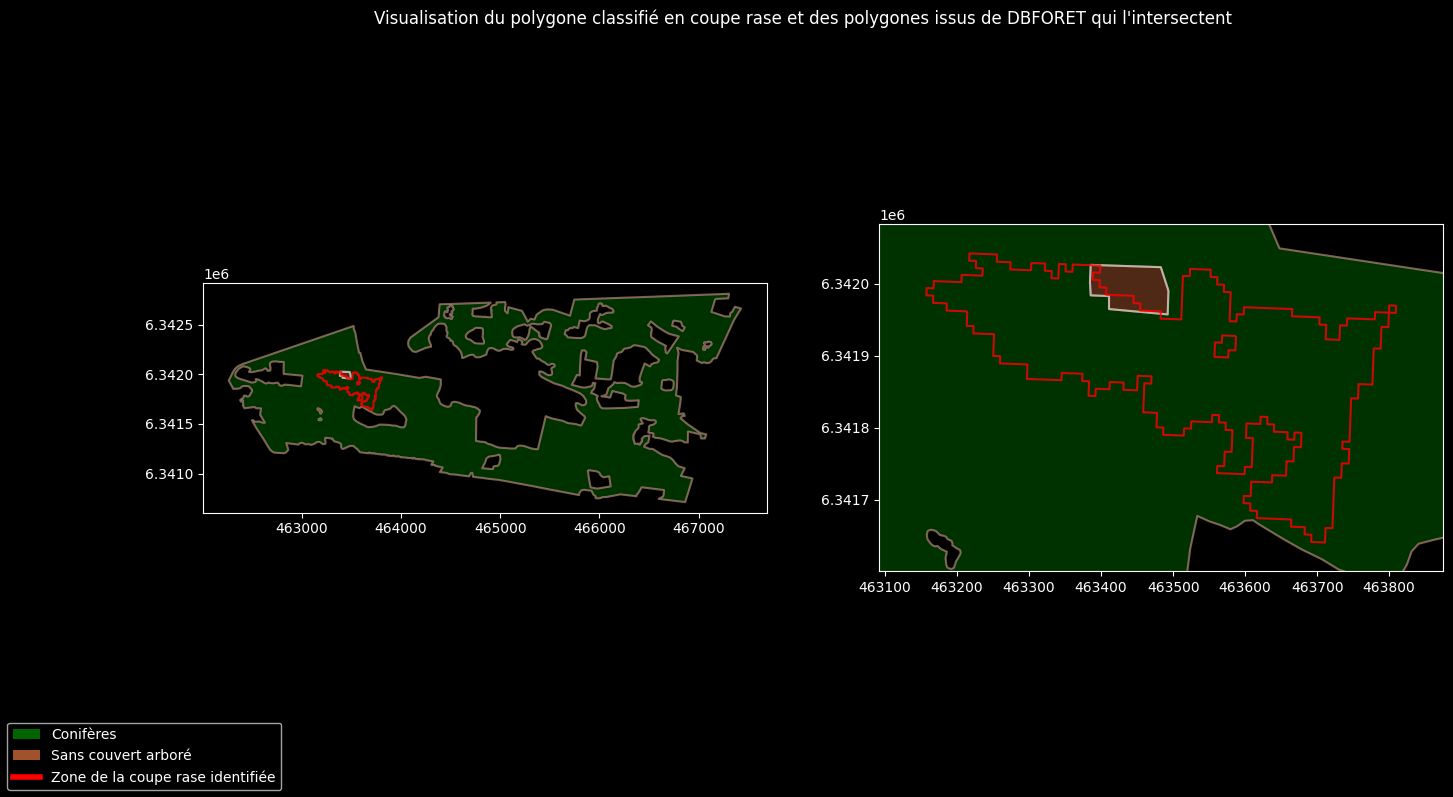

In [18]:
plt.style.use("dark_background")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

case_0_inter_bdf_plot = case_0_inter_bdf.set_geometry("bdf_geometry")
cmap_boundaries = matplotlib.colormaps["Pastel1"]
color_boundaries = iter(cmap_boundaries(np.linspace(0, 1, len(case_0_inter_bdf_plot))))
for TFV, TFV_group in case_0_inter_bdf_plot.groupby("TFV_SIMPLE"):
    TFV_group.plot(ax=axes[0], color=plot_palette[TFV], alpha=0.5)
for idx in case_0_inter_bdf_plot.index:
    case_0_inter_bdf_plot.loc[[idx]].boundary.plot(
        ax=axes[0], color=next(color_boundaries), alpha=0.5
    )
case_0_inter_bdf_plot = case_0_inter_bdf.set_geometry("geometry")
case_0_inter_bdf_plot.iloc[[0]].boundary.plot(ax=axes[0], color="r", alpha=0.8)

case_0_inter_bdf_plot = case_0_inter_bdf.set_geometry("bdf_geometry")
cmap_boundaries = matplotlib.colormaps["Pastel1"]
color_boundaries = iter(cmap_boundaries(np.linspace(0, 1, len(case_0_inter_bdf_plot))))
for TFV, TFV_group in case_0_inter_bdf_plot.groupby("TFV_SIMPLE"):
    TFV_group.plot(ax=axes[1], color=plot_palette[TFV], alpha=0.5)
for idx in case_0_inter_bdf_plot.index:
    case_0_inter_bdf_plot.loc[[idx]].boundary.plot(
        ax=axes[1], color=next(color_boundaries), alpha=0.5
    )
case_0_inter_bdf_plot = case_0_inter_bdf.set_geometry("geometry")
case_0_inter_bdf_plot.iloc[[0]].boundary.plot(ax=axes[1], color="r", alpha=0.8)
minx, miny, maxx, maxy = np.array(case_0_inter_bdf_plot.iloc[0].geometry.bounds)
minx, miny, maxx, maxy = (
    minx - (maxx - minx) / 10,
    miny - (maxy - miny) / 10,
    maxx + (maxx - minx) / 10,
    maxy + (maxy - miny) / 10,
)
axes[1].set_xlim(minx, maxx)
axes[1].set_ylim(miny, maxy)

legend_elements = [
    matplotlib.patches.Patch(facecolor=plot_palette[TFV], label=TFV)
    for TFV in case_0_inter_bdf_plot.TFV_SIMPLE.unique()
]
legend_elements.append(
    matplotlib.lines.Line2D([0], [0], color="r", lw=4, label="Zone de la coupe rase identifiée")
)
fig.legend(handles=legend_elements, loc="lower left")
fig.suptitle(
    "Visualisation du polygone classifié en coupe rase et des polygones issus de DBFORET qui l'intersectent"
)
plt.show()

In [19]:
case_0_inter_bdf_cat = (
    case_0_inter_bdf.groupby("TFV_SIMPLE").sum("relative_intersection_area").reset_index()
)
case_0_inter_bdf_cat["relative_intersection_area"] = (
    case_0_inter_bdf_cat["relative_intersection_area"]
    / case_0_inter_bdf_cat["relative_intersection_area"].sum()
)
case_0_inter_bdf_cat

,TFV_SIMPLE,relative_intersection_area
0,Conifères,0.985487
1,Sans couvert arboré,0.014513


In [20]:
case_0_inter_bdf_cat["TFV_COMPO"] = case_0_inter_bdf_cat.apply(
    lambda x: f"{x.relative_intersection_area:.1%} {x.TFV_SIMPLE}", axis=1
)
case_0_inter_bdf_cat

,TFV_SIMPLE,relative_intersection_area,TFV_COMPO
0,Conifères,0.985487,98.5% Conifères
1,Sans couvert arboré,0.014513,1.5% Sans couvert arboré


In [21]:
case_0_final_result = " | ".join(case_0_inter_bdf_cat.TFV_COMPO)
case_0_final_result

'98.5% Conifères | 1.5% Sans couvert arboré'

## Case 3: the clear cut polygon overlaps multiple departments

In [22]:
gdf_cuts = gpd.read_file("../data/geometries/gdf_sample_clear_cuts.geojson")
gdf_departments = gpd.read_file("../data/geometries/all_departments.geojson").to_crs(
    "EPSG:2154"
)

In [23]:
test_dep_sjoin = gdf_cuts.sjoin(gdf_departments, how="left", predicate="intersects")

In [24]:
case_3 = test_dep_sjoin.loc[[3]].drop(columns="index_right")
case_3_inter_deps = case_3.code
case_3_deps = gdf_departments[gdf_departments.code.isin(case_3_inter_deps)]
case_3_deps

,code,nom,geometry
7,40,Landes,"POLYGON ((361773.9 6383395.8, 366732 6384644.4..."
54,33,Gironde,"POLYGON ((386164.2 6505244.8, 393457.6 6496141..."


In [25]:
bdf_src_dirpath = Path("../data/ign/bdforet_2_0/tfv_simple/")
files = [gpd.read_file(bdf_src_dirpath / f"{dep_code}.shp") for dep_code in case_3_deps.code]
case_3_bdf_data = gpd.GeoDataFrame(pd.concat(files, ignore_index=True), crs="EPSG:2154")
case_3_bdf_data["bdf_geometry"] = case_3_bdf_data.geometry
case_3_bdf_data

,TFV_SIMPLE,geometry,bdf_geometry
0,Lande,"POLYGON ((367716.652 6372715.968, 367726.5 637...","POLYGON ((367716.652 6372715.968, 367726.5 637..."
1,Lande,"POLYGON ((367000 6379450, 366997.5 6379452, 36...","POLYGON ((367000 6379450, 366997.5 6379452, 36..."
2,Lande,"POLYGON ((367525 6373050, 367524.3 6373047, 36...","POLYGON ((367525 6373050, 367524.3 6373047, 36..."
3,Lande,"POLYGON ((373111.5 6384122, 373114.5 6384123.3...","POLYGON ((373111.5 6384122, 373114.5 6384123.3..."
4,Lande,"POLYGON ((375425.191 6385772.939, 375426.5 638...","POLYGON ((375425.191 6385772.939, 375426.5 638..."
...,...,...,...
96219,Feuillus,"POLYGON ((459913.5 6410057, 459920.8 6410052, ...","POLYGON ((459913.5 6410057, 459920.8 6410052, ..."
96220,Feuillus,"POLYGON ((405541.8 6420060, 405541.5 6420049, ...","POLYGON ((405541.8 6420060, 405541.5 6420049, ..."
96221,Feuillus,"POLYGON ((434283.8 6424982, 434282 6424980.3, ...","POLYGON ((434283.8 6424982, 434282 6424980.3, ..."
96222,Feuillus,"POLYGON ((381507.289 6405190.919, 381509.184 6...","POLYGON ((381507.289 6405190.919, 381509.184 6..."


In [26]:
case_3_inter_bdf = case_3.iloc[[0]].sjoin(case_3_bdf_data, how="left", predicate="intersects")
case_3_inter_bdf.index = case_3_inter_bdf.index_right
case_3_inter_bdf = case_3_inter_bdf[["geometry", "TFV_SIMPLE", "bdf_geometry"]]
case_3_inter_bdf

,geometry,TFV_SIMPLE,bdf_geometry
index_right,,,
29156,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Conifères,"POLYGON ((445625.583 6357220.826, 445756.628 6..."
68872,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Conifères,"POLYGON ((449784.8 6359302, 449784 6359297.3, ..."
5517,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((446898.561 6355453.778, 446854.901 6..."
5518,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((446200.109 6355645.536, 446204.829 6..."
89975,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((447150.136 6355913.015, 447143.522 6..."
89789,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((446648.491 6355553.943, 446548.464 6..."


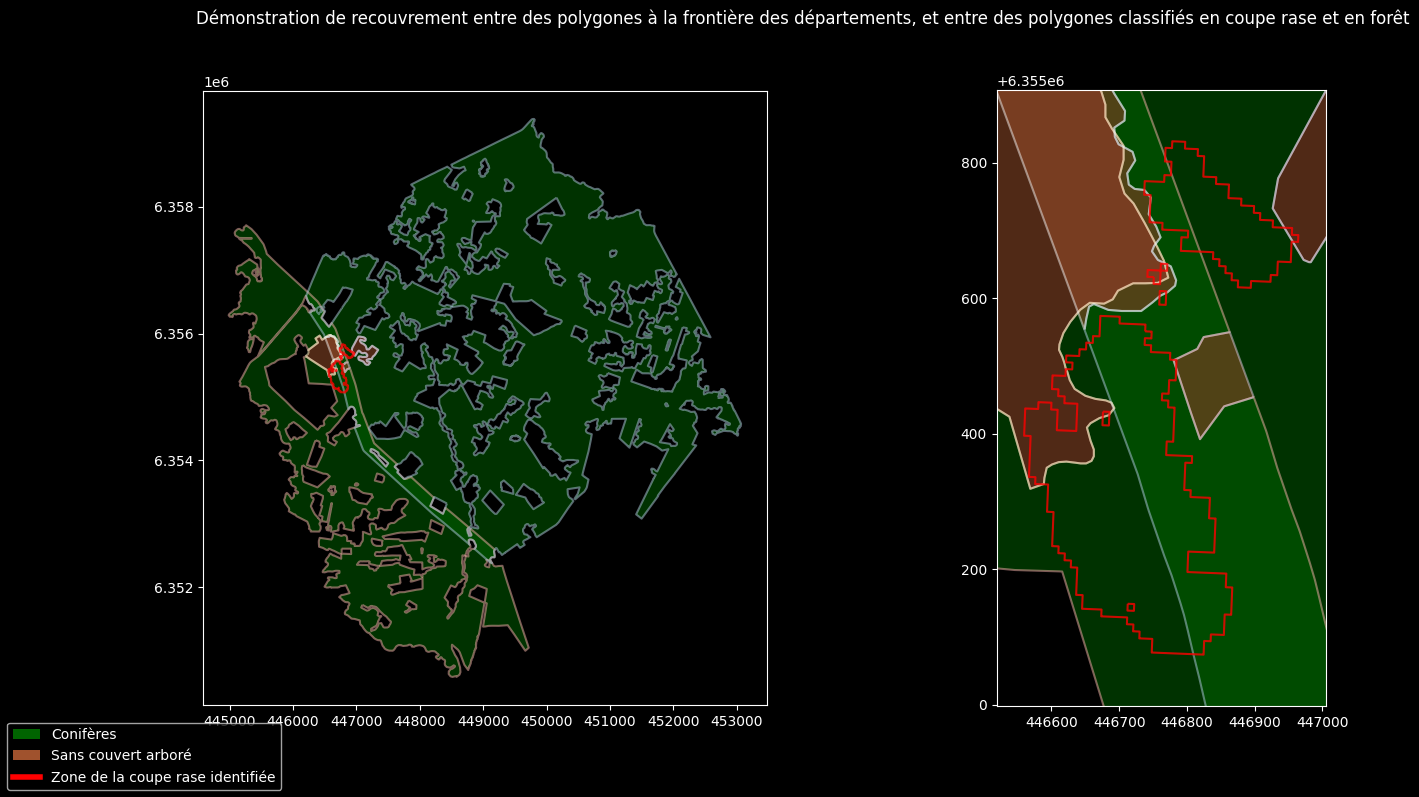

In [27]:
plt.style.use("dark_background")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

case_3_inter_bdf_plot = case_3_inter_bdf.set_geometry("bdf_geometry")
cmap_boundaries = matplotlib.colormaps["Pastel1"]
color_boundaries = iter(cmap_boundaries(np.linspace(0, 1, len(case_3_inter_bdf_plot))))
for TFV, TFV_group in case_3_inter_bdf_plot.groupby("TFV_SIMPLE"):
    TFV_group.plot(ax=axes[0], color=plot_palette[TFV], alpha=0.5)
for idx in case_3_inter_bdf_plot.index:
    case_3_inter_bdf_plot.loc[[idx]].boundary.plot(
        ax=axes[0], color=next(color_boundaries), alpha=0.5
    )
case_3_inter_bdf_plot = case_3_inter_bdf.set_geometry("geometry")
case_3_inter_bdf_plot.iloc[[0]].boundary.plot(ax=axes[0], color="r", alpha=0.8)

case_3_inter_bdf_plot = case_3_inter_bdf.set_geometry("bdf_geometry")
cmap_boundaries = matplotlib.colormaps["Pastel1"]
color_boundaries = iter(cmap_boundaries(np.linspace(0, 1, len(case_3_inter_bdf_plot))))
for TFV, TFV_group in case_3_inter_bdf_plot.groupby("TFV_SIMPLE"):
    TFV_group.plot(ax=axes[1], color=plot_palette[TFV], alpha=0.5)
for idx in case_3_inter_bdf_plot.index:
    case_3_inter_bdf_plot.loc[[idx]].boundary.plot(
        ax=axes[1], color=next(color_boundaries), alpha=0.5
    )
case_3_inter_bdf_plot = case_3_inter_bdf.set_geometry("geometry")
case_3_inter_bdf_plot.iloc[[0]].boundary.plot(ax=axes[1], color="r", alpha=0.8)
minx, miny, maxx, maxy = np.array(case_3_inter_bdf_plot.iloc[0].geometry.bounds)
minx, miny, maxx, maxy = (
    minx - (maxx - minx) / 10,
    miny - (maxy - miny) / 10,
    maxx + (maxx - minx) / 10,
    maxy + (maxy - miny) / 10,
)
axes[1].set_xlim(minx, maxx)
axes[1].set_ylim(miny, maxy)

legend_elements = [
    matplotlib.patches.Patch(facecolor=plot_palette[TFV], label=TFV)
    for TFV in case_3_inter_bdf_plot.TFV_SIMPLE.unique()
]
legend_elements.append(
    matplotlib.lines.Line2D([0], [0], color="r", lw=4, label="Zone de la coupe rase identifiée")
)
fig.legend(handles=legend_elements, loc="lower left")
fig.suptitle(
    "Démonstration de recouvrement entre des polygones à la frontière des départements, et entre des polygones classifiés en coupe rase et en forêt"
)
plt.show()

In [28]:
case_3_inter_bdf["relative_intersection_area"] = (
    case_3_inter_bdf.geometry.intersection(case_3_bdf_data, align=True).area
    / case_3_inter_bdf.geometry.area
)

case_3_inter_bdf = case_3_inter_bdf.sort_values("relative_intersection_area", ascending=False)
case_3_inter_bdf

,geometry,TFV_SIMPLE,bdf_geometry,relative_intersection_area
index_right,,,,
29156,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Conifères,"POLYGON ((445625.583 6357220.826, 445756.628 6...",0.747980
68872,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Conifères,"POLYGON ((449784.8 6359302, 449784 6359297.3, ...",0.525279
5518,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((446200.109 6355645.536, 446204.829 6...",0.089753
89789,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((446648.491 6355553.943, 446548.464 6...",0.004359
89975,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((447150.136 6355913.015, 447143.522 6...",0.001758
5517,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",Sans couvert arboré,"POLYGON ((446898.561 6355453.778, 446854.901 6...",0.000242


In [29]:
case_3_inter_bdf_cat = (
    case_3_inter_bdf.groupby("TFV_SIMPLE").sum("relative_intersection_area").reset_index()
)
case_3_inter_bdf_cat["relative_intersection_area"] = (
    case_3_inter_bdf_cat["relative_intersection_area"]
    / case_3_inter_bdf_cat["relative_intersection_area"].sum()
)
case_3_inter_bdf_cat

,TFV_SIMPLE,relative_intersection_area
0,Conifères,0.929813
1,Sans couvert arboré,0.070187


In [30]:
case_3_inter_bdf_cat["TFV_COMPO"] = case_3_inter_bdf_cat.apply(
    lambda x: f"{x.relative_intersection_area:.1%} {x.TFV_SIMPLE}", axis=1
)
case_3_inter_bdf_cat

,TFV_SIMPLE,relative_intersection_area,TFV_COMPO
0,Conifères,0.929813,93.0% Conifères
1,Sans couvert arboré,0.070187,7.0% Sans couvert arboré


In [31]:
case_3_final_result = " | ".join(case_3_inter_bdf_cat.TFV_COMPO)
case_3_final_result

'93.0% Conifères | 7.0% Sans couvert arboré'

## Gather all the process steps into a geodataframe-processing function

In [48]:
gdf_cuts = gpd.read_file("../data/geometries/gdf_sample_clear_cuts.geojson")
gdf_departments = gpd.read_file("../data/geometries/all_departments.geojson").to_crs(
    "EPSG:2154"
)

In [57]:
def fetch_forest_cover_type(
    gdf_cuts: gpd.GeoDataFrame, include_numeric: bool = False
) -> gpd.GeoDataFrame:
    """Evaluates the type of forest cover for a geodataframe of clear cut polygons in France."""

    if include_numeric:
        all_num_cols = [f"RIA {TFV}" for TFV in plot_palette]
        gdf_cuts[all_num_cols] = np.nan

    department_sjoin = gdf_cuts.sjoin(gdf_departments, how="left", predicate="intersects")

    for cut_idx in tqdm(gdf_cuts.index):
        if np.isnan(department_sjoin.loc[cut_idx, "index_right"]).all():
            print(
                f"ERROR: polygon is outside known mainland french territory for index {cut_idx}."
            )
            continue

        department_sjoin_cut = department_sjoin.loc[[cut_idx]].drop(columns="index_right")

        inter_deps = department_sjoin_cut.code
        deps = gdf_departments[gdf_departments.code.isin(inter_deps)]

        bdf_src_dirpath = Path("../data/ign/bdforet_2_0/tfv_simple/")
        files = [gpd.read_file(bdf_src_dirpath / f"{dep_code}.shp") for dep_code in deps.code]
        bdf_data = gpd.GeoDataFrame(pd.concat(files, ignore_index=True), crs="EPSG:2154")
        bdf_data["bdf_geometry"] = bdf_data.geometry

        inter_bdf = department_sjoin_cut.iloc[[0]].sjoin(
            bdf_data, how="left", predicate="intersects"
        )
        inter_bdf.index = inter_bdf.index_right
        inter_bdf = inter_bdf[["geometry", "TFV_SIMPLE", "bdf_geometry"]]

        inter_bdf["relative_intersection_area"] = (
            inter_bdf.geometry.intersection(bdf_data, align=True).area / inter_bdf.geometry.area
        )

        inter_bdf_cat = (
            inter_bdf.groupby("TFV_SIMPLE").sum("relative_intersection_area").reset_index()
        )
        inter_bdf_cat["relative_intersection_area"] = (
            inter_bdf_cat["relative_intersection_area"]
            / inter_bdf_cat["relative_intersection_area"].sum()
        )
        inter_bdf_cat["TFV_COMPO"] = inter_bdf_cat.apply(
            lambda x: f"{x.relative_intersection_area:.1%} {x.TFV_SIMPLE}", axis=1
        )
        tfv_compo = " | ".join(inter_bdf_cat.TFV_COMPO)
        gdf_cuts.loc[cut_idx, "TFV_COMPO"] = tfv_compo

        if include_numeric:
            num_cols = [f"RIA {TFV}" for TFV in inter_bdf_cat.TFV_SIMPLE.values]
            gdf_cuts.loc[cut_idx, num_cols] = inter_bdf_cat.relative_intersection_area.values

    if include_numeric:
        valid_rows = gdf_cuts.TFV_COMPO.notna()
        gdf_cuts.loc[valid_rows, all_num_cols] = gdf_cuts.loc[valid_rows, all_num_cols].fillna(
            0
        )

    return gdf_cuts


def plot_forest_cover_type(gdf_cuts: gpd.GeoDataFrame) -> None:
    """Plots the type of forest cover over every polygon for a geodataframe of clear cut polygons in France."""

    department_sjoin = gdf_cuts.sjoin(gdf_departments, how="left", predicate="intersects")

    for cut_idx in gdf_cuts.index:
        if np.isnan(department_sjoin.loc[cut_idx, "index_right"]).all():
            print(
                f"ERROR: polygon is outside known mainland french territory for index {cut_idx}."
            )
            continue

        department_sjoin_cut = department_sjoin.loc[[cut_idx]].drop(columns="index_right")

        inter_deps = department_sjoin_cut.code
        deps = gdf_departments[gdf_departments.code.isin(inter_deps)]

        bdf_src_dirpath = Path("../data/ign/bdforet_2_0/tfv_simple/")
        files = [gpd.read_file(bdf_src_dirpath / f"{dep_code}.shp") for dep_code in deps.code]
        bdf_data = gpd.GeoDataFrame(pd.concat(files, ignore_index=True), crs="EPSG:2154")
        bdf_data["bdf_geometry"] = bdf_data.geometry

        inter_bdf = department_sjoin_cut.iloc[[0]].sjoin(
            bdf_data, how="left", predicate="intersects"
        )
        inter_bdf.index = inter_bdf.index_right
        inter_bdf = inter_bdf[["geometry", "TFV_SIMPLE", "bdf_geometry"]]

        plt.style.use("dark_background")
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        inter_bdf_plot = inter_bdf.set_geometry("bdf_geometry")
        cmap_boundaries = matplotlib.colormaps["Pastel1"]
        color_boundaries = iter(cmap_boundaries(np.linspace(0, 1, len(inter_bdf_plot))))
        for TFV, TFV_group in inter_bdf_plot.groupby("TFV_SIMPLE"):
            TFV_group.plot(ax=axes[0], color=plot_palette[TFV], alpha=0.5)
        for idx in inter_bdf_plot.index:
            inter_bdf_plot.loc[[idx]].boundary.plot(
                ax=axes[0], color=next(color_boundaries), alpha=0.5
            )
        inter_bdf_plot = inter_bdf.set_geometry("geometry")
        inter_bdf_plot.iloc[[0]].boundary.plot(ax=axes[0], color="r", alpha=0.8)

        inter_bdf_plot = inter_bdf.set_geometry("bdf_geometry")
        cmap_boundaries = matplotlib.colormaps["Pastel1"]
        color_boundaries = iter(cmap_boundaries(np.linspace(0, 1, len(inter_bdf_plot))))
        for TFV, TFV_group in inter_bdf_plot.groupby("TFV_SIMPLE"):
            TFV_group.plot(ax=axes[1], color=plot_palette[TFV], alpha=0.5)
        for idx in inter_bdf_plot.index:
            inter_bdf_plot.loc[[idx]].boundary.plot(
                ax=axes[1], color=next(color_boundaries), alpha=0.5
            )
        inter_bdf_plot = inter_bdf.set_geometry("geometry")
        inter_bdf_plot.iloc[[0]].boundary.plot(ax=axes[1], color="r", alpha=0.8)
        minx, miny, maxx, maxy = np.array(inter_bdf_plot.iloc[0].geometry.bounds)
        minx, miny, maxx, maxy = (
            minx - (maxx - minx) / 10,
            miny - (maxy - miny) / 10,
            maxx + (maxx - minx) / 10,
            maxy + (maxy - miny) / 10,
        )
        axes[1].set_xlim(minx, maxx)
        axes[1].set_ylim(miny, maxy)

        legend_elements = [
            matplotlib.patches.Patch(facecolor=plot_palette[TFV], label=TFV)
            for TFV in inter_bdf_plot.TFV_SIMPLE.unique()
        ]
        legend_elements.append(
            matplotlib.lines.Line2D(
                [0], [0], color="r", lw=4, label="Zone de la coupe rase identifiée"
            )
        )
        fig.legend(handles=legend_elements, loc="lower left")
        fig.suptitle(f"Index de coupe rase: {cut_idx}")
        plt.show()

In [58]:
fetch_forest_cover_type(gdf_cuts)

 31%|█████████████████████████████████████████████▌                                                                                                      | 4/13 [00:04<00:12,  1.35s/it]

ERROR: polygon is outside known mainland french territory for index 4.


 46%|████████████████████████████████████████████████████████████████████▎                                                                               | 6/13 [00:05<00:05,  1.37it/s]

ERROR: polygon is outside known mainland french territory for index 6.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.49it/s]

ERROR: polygon is outside known mainland french territory for index 11.
ERROR: polygon is outside known mainland french territory for index 12.


,clear_cut_group,date_min,date_max,days_delta,clear_cut_group_size,area_ha,geometry,RIA Sans couvert arboré,RIA Feuillus,RIA Conifères,RIA Mixte,RIA Peupleraie,RIA Lande,RIA Formation herbacée,TFV_COMPO
0,40063,2024-06-28,2024-08-03,36,28,10.027192,"POLYGON ((463214.121 6341961.718, 463185.363 6...",0.014513,0.000000,0.985487,0.0,0.0,0.0,0.0,98.5% Conifères | 1.5% Sans couvert arboré
1,48216,2024-06-21,2024-08-03,43,87,10.500394,"POLYGON ((367544.441 6351902.694, 367525.299 6...",0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,100.0% Conifères
2,30485,2024-06-15,2024-08-02,48,33,10.949711,"POLYGON ((490353.961 6445604.284, 490344.532 6...",0.001408,0.022047,0.976545,0.0,0.0,0.0,0.0,97.7% Conifères | 2.2% Feuillus | 0.1% Sans co...
3,39066,2024-06-03,2024-08-02,60,13,11.162990,"MULTIPOLYGON (((446856.75 6355636.859, 446856....",0.070187,0.000000,0.929813,0.0,0.0,0.0,0.0,93.0% Conifères | 7.0% Sans couvert arboré
4,11933,2024-05-02,2024-05-14,12,16,11.277782,"POLYGON ((1004010.877 6679036.791, 1004010.877...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20917,2024-06-15,2024-08-03,49,119,11.643299,"MULTIPOLYGON (((462466.889 6599030.176, 462466...",0.455100,0.544900,0.000000,0.0,0.0,0.0,0.0,54.5% Feuillus | 45.5% Sans couvert arboré
6,9622,2024-03-08,2024-05-07,60,51,12.254396,"MULTIPOLYGON (((1058292.53 6502565.819, 105827...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,50028,2024-06-15,2024-08-02,48,80,12.267579,"POLYGON ((348349.487 6303934.768, 348349.487 6...",0.067675,0.000000,0.932325,0.0,0.0,0.0,0.0,93.2% Conifères | 6.8% Sans couvert arboré
8,41240,2024-06-27,2024-08-03,37,78,12.596832,"POLYGON ((432921.421 6431708.372, 432920.989 6...",0.998136,0.001864,0.000000,0.0,0.0,0.0,0.0,0.2% Feuillus | 99.8% Sans couvert arboré
9,47864,2024-06-15,2024-08-02,48,54,12.629194,"POLYGON ((364174.611 6344851.094, 364165.029 6...",0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,100.0% Conifères


We observe that part or all of some detected clear cuts area is already classified as deforested terrain. This signals some inconsistencies between the BDFORET and Sufosat data. Indeed, while all our test clear cuts are supposed to have occurred in 2024, the BDFORET dataset was built from data spanning between 2007 and 2018, with some minor adjustments up until 2022.

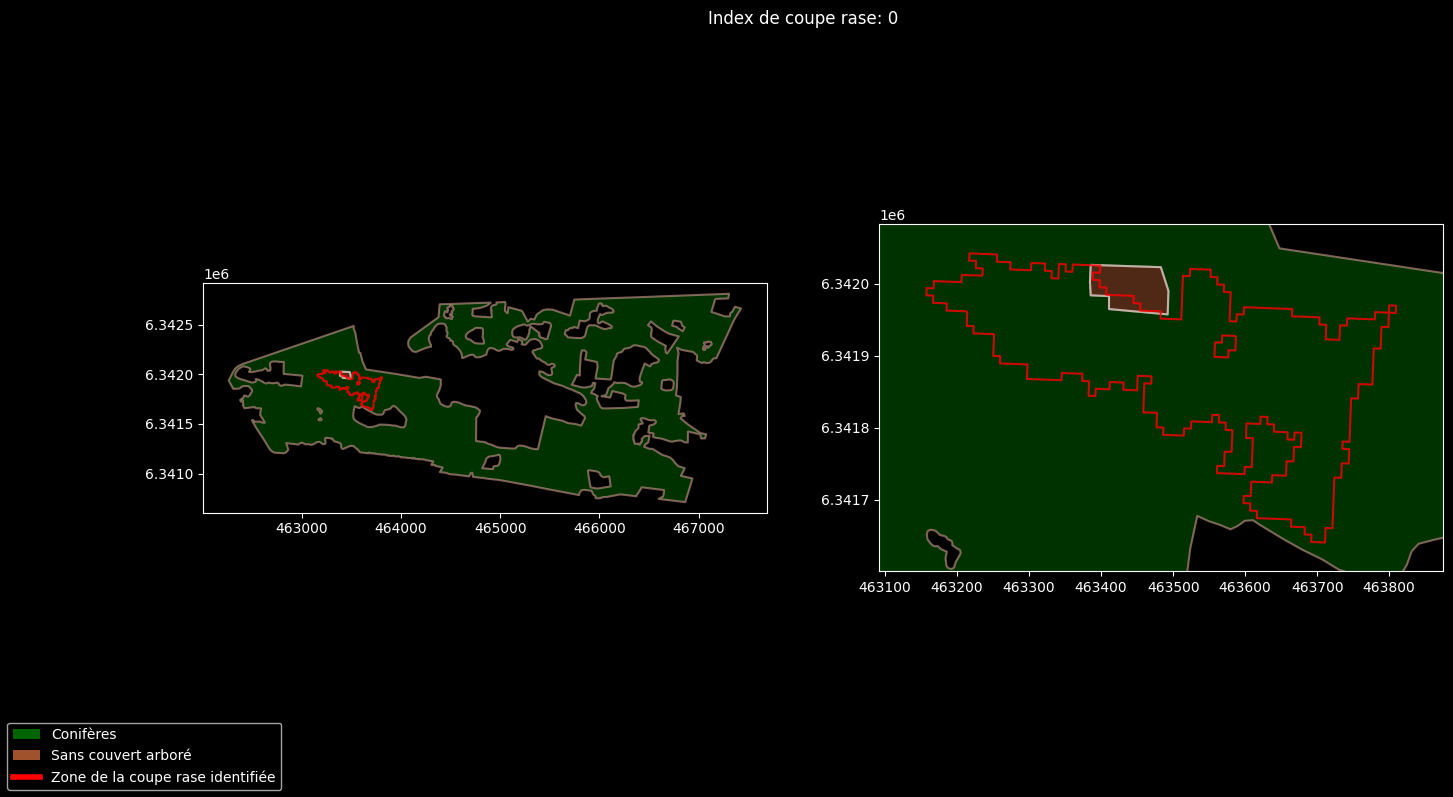

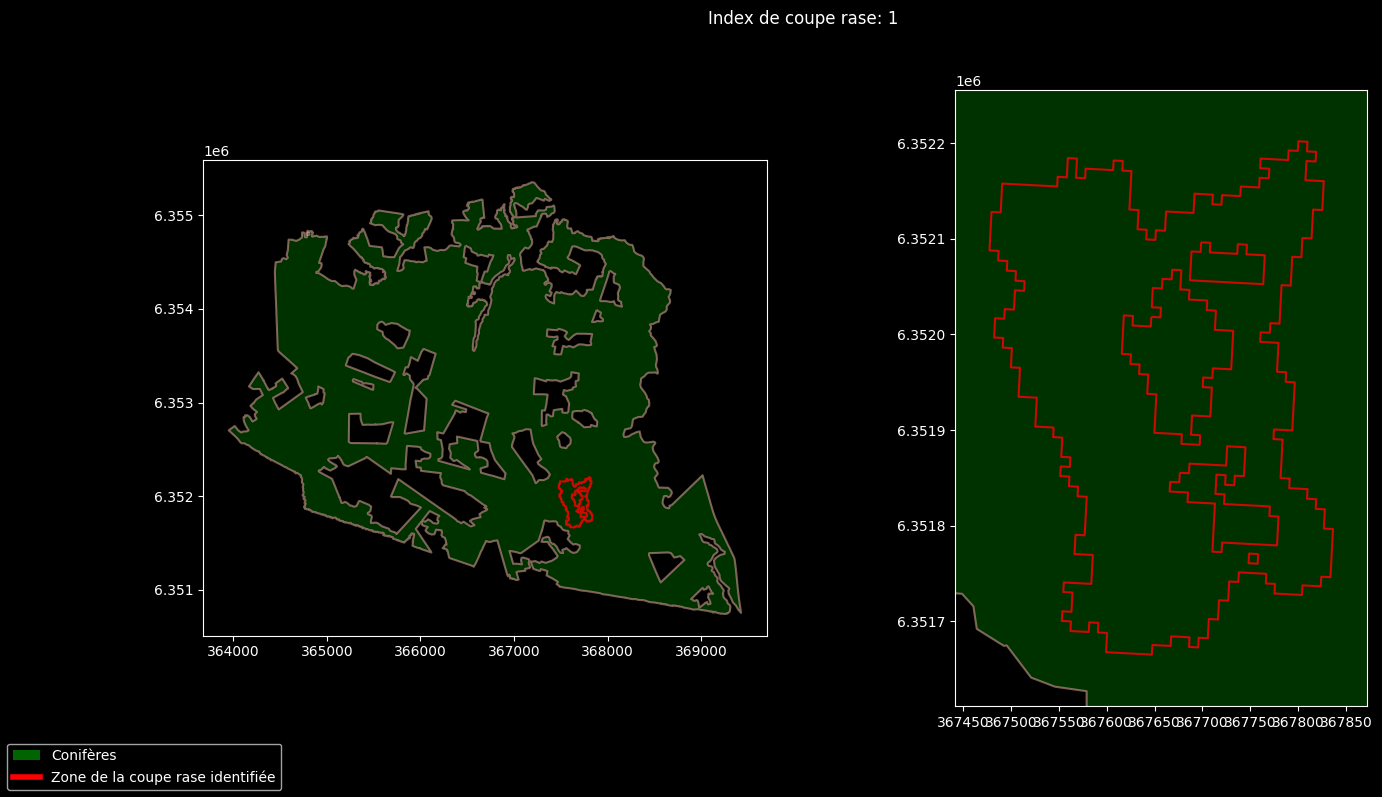

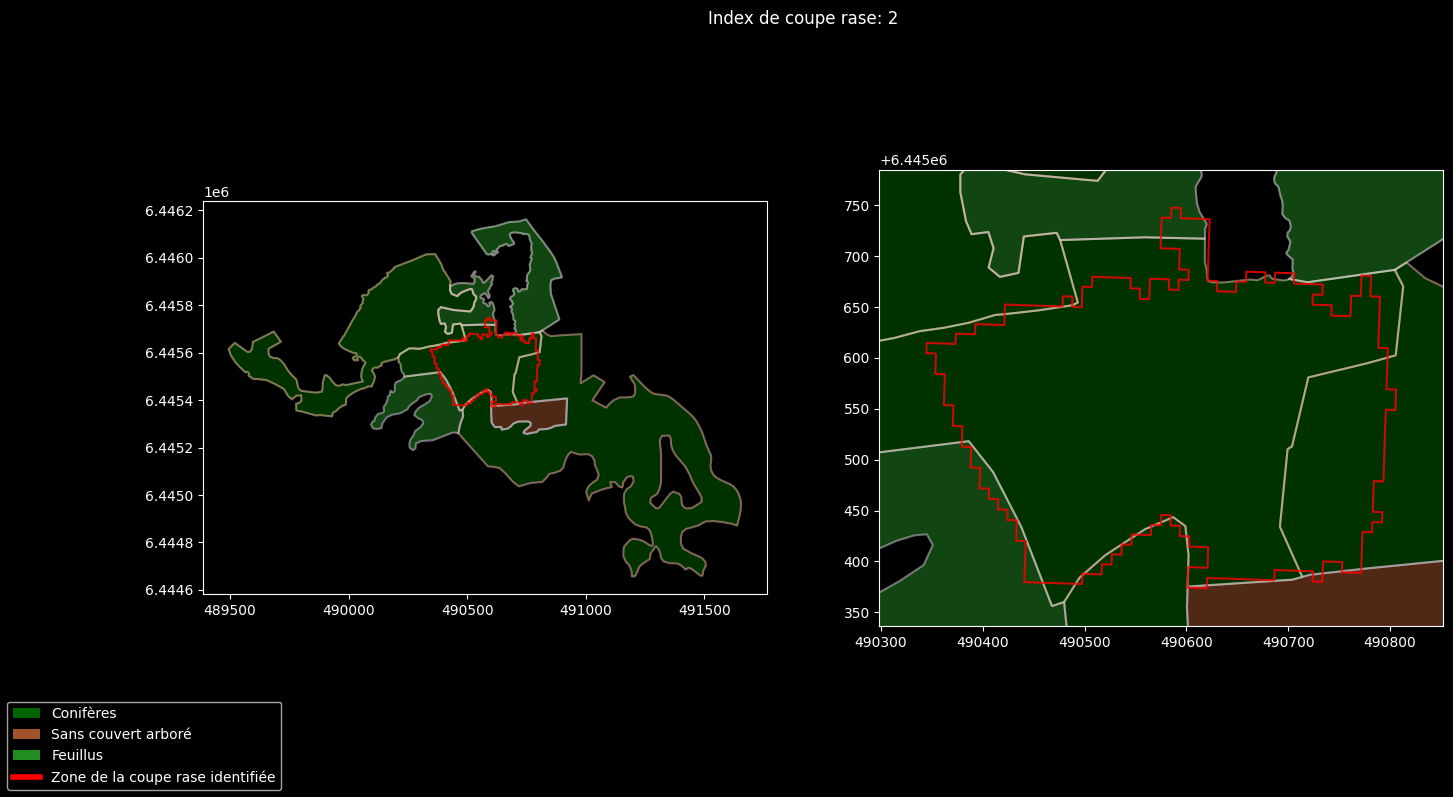

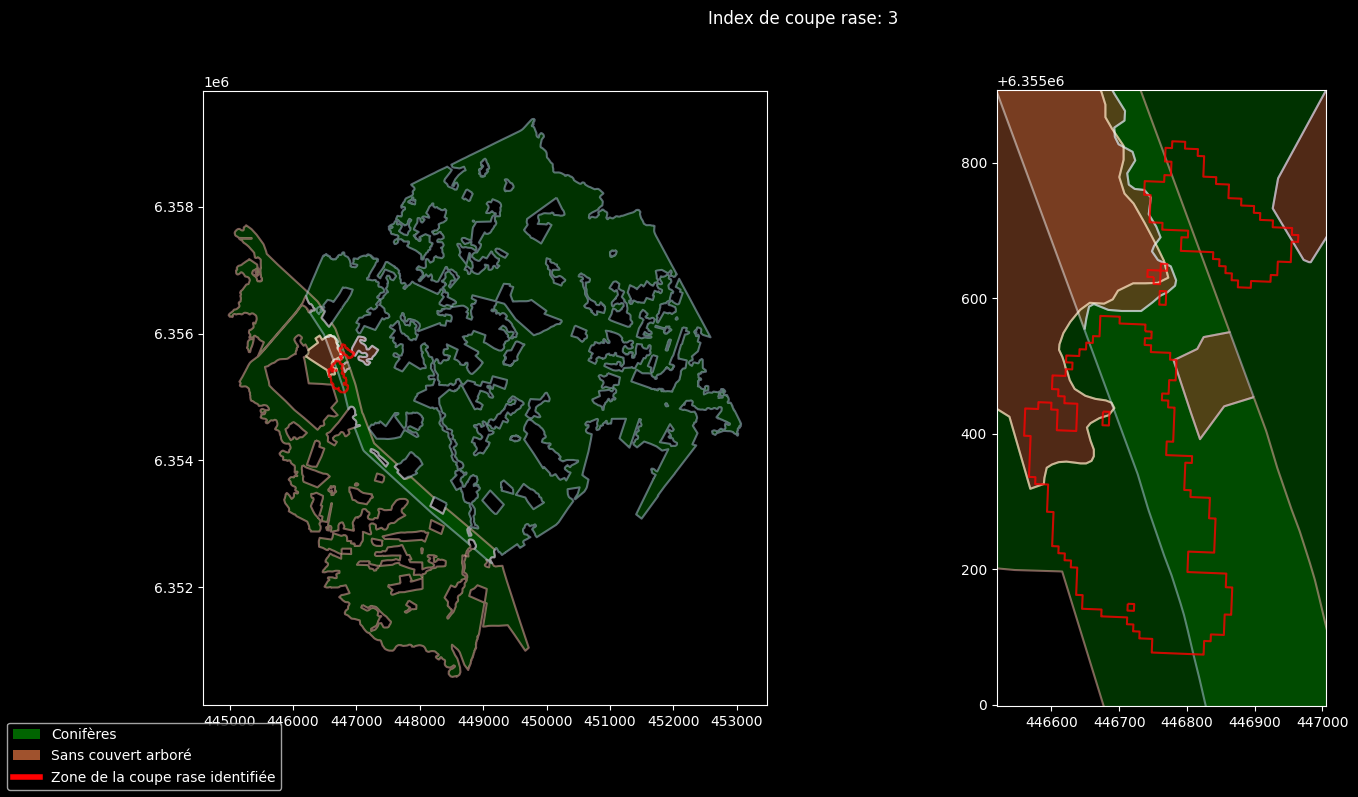

ERROR: polygon is outside known mainland french territory for index 4.


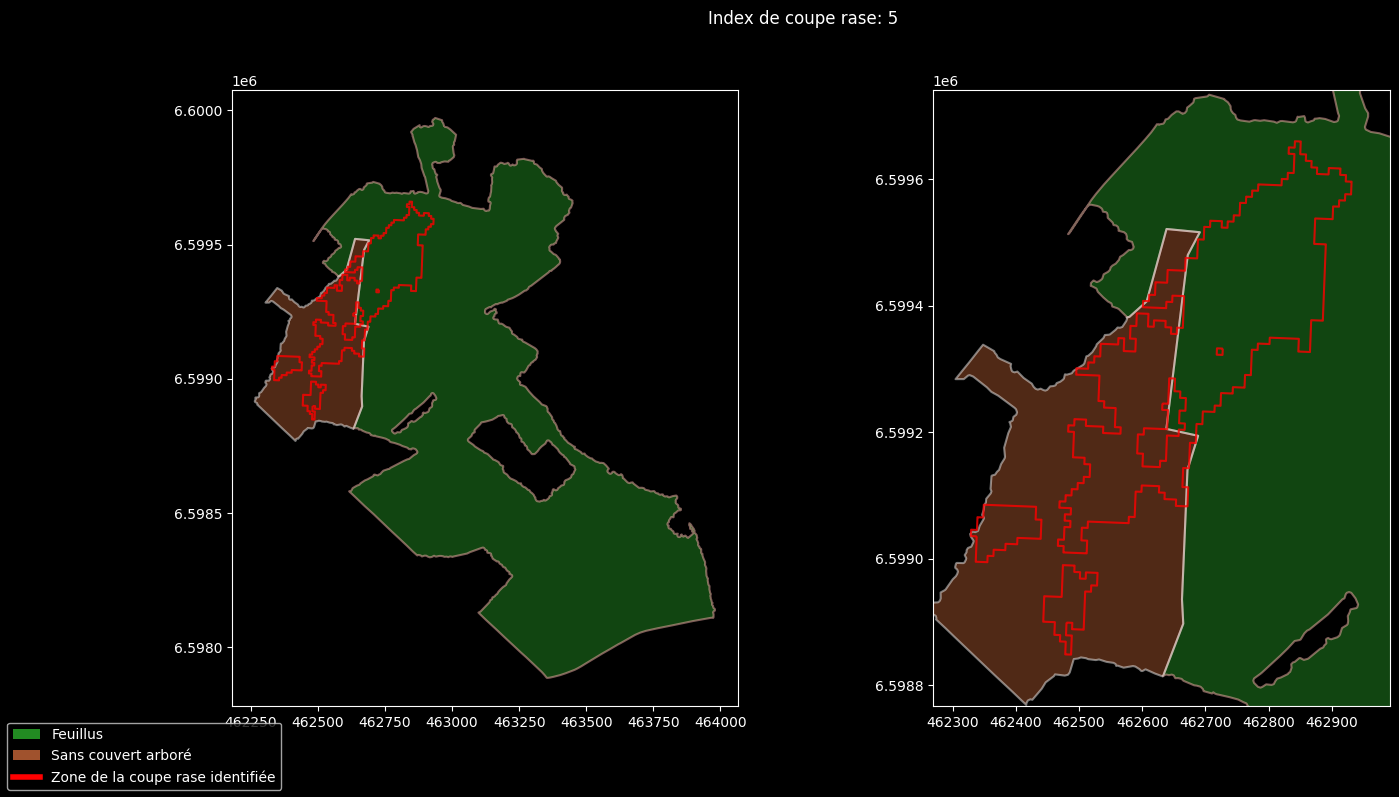

ERROR: polygon is outside known mainland french territory for index 6.


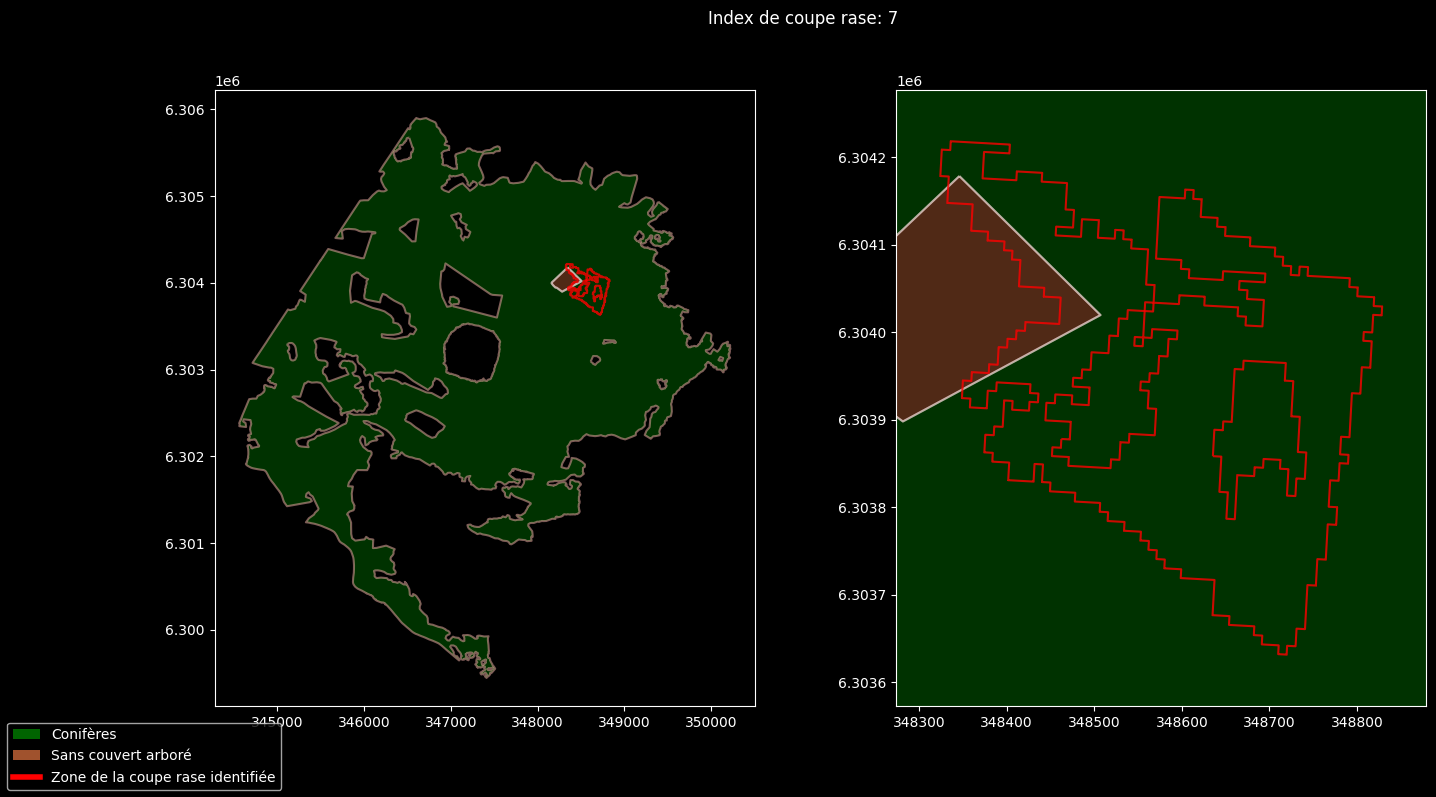

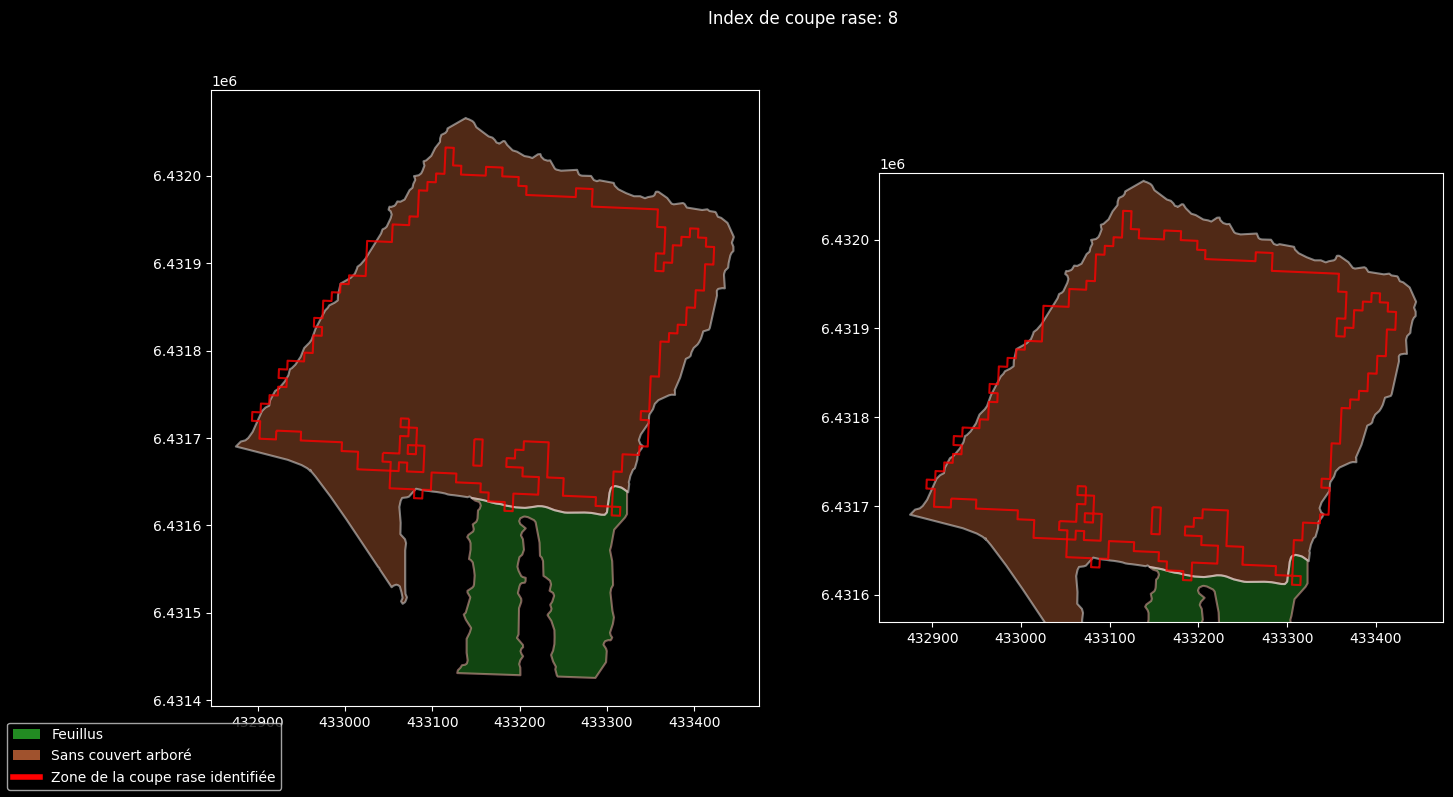

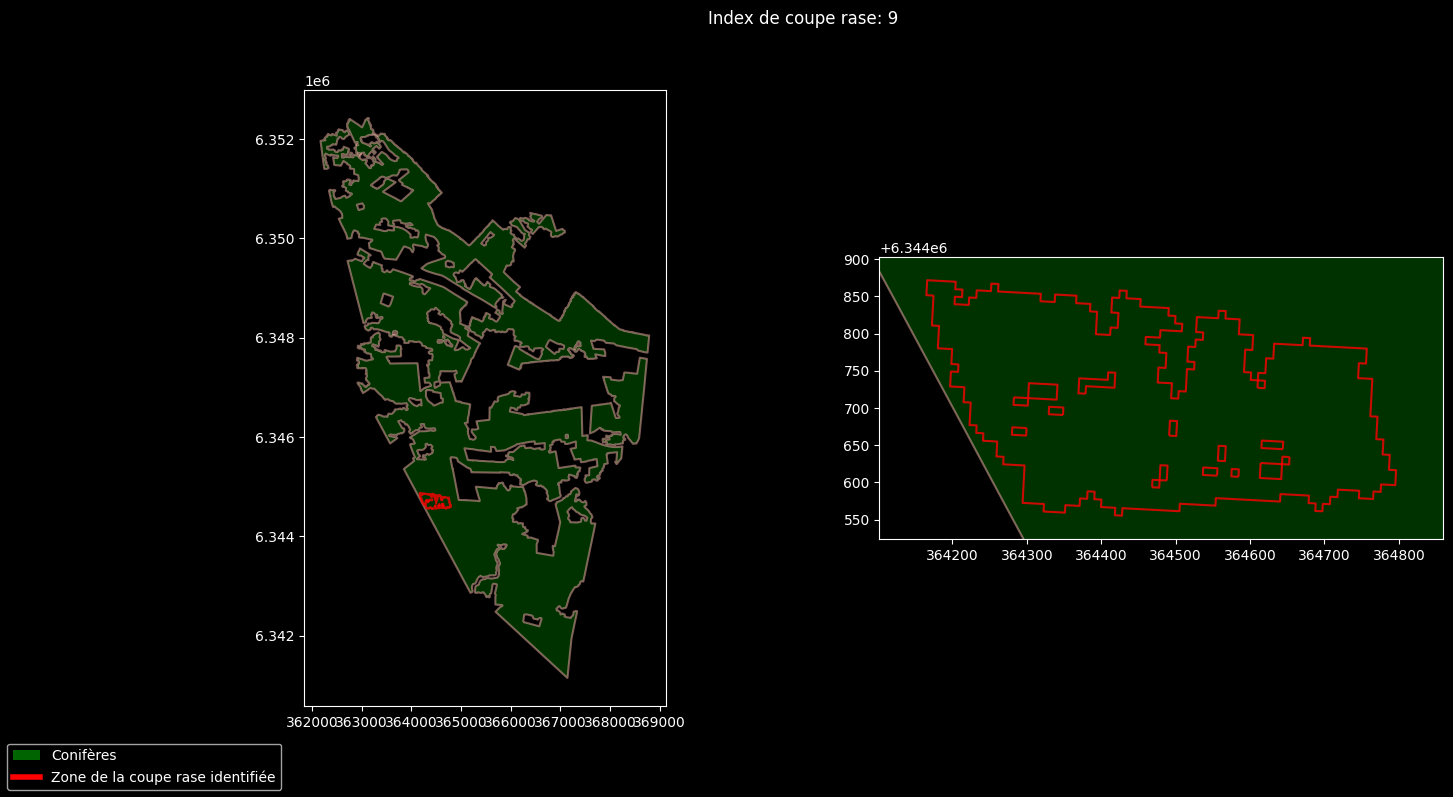

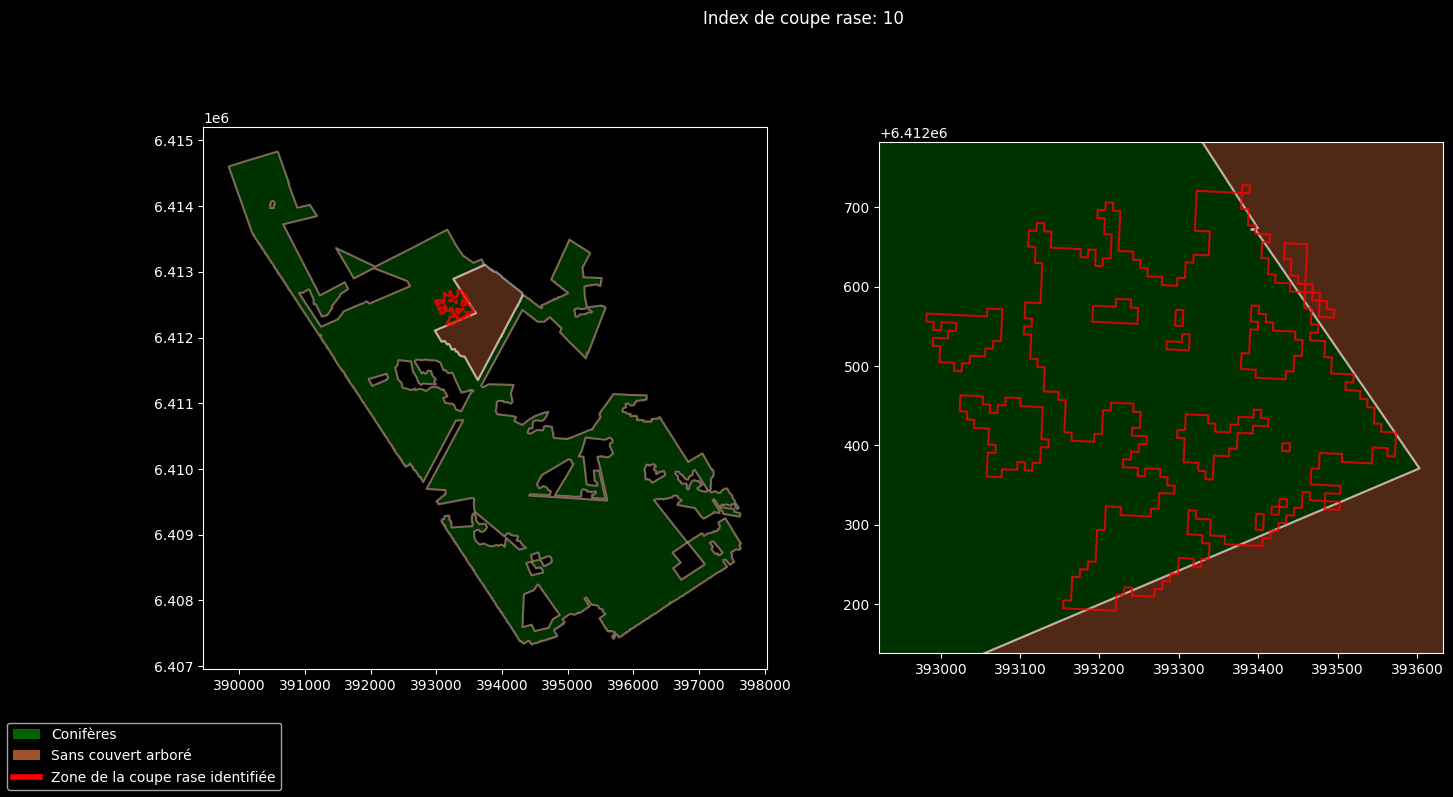

ERROR: polygon is outside known mainland french territory for index 11.
ERROR: polygon is outside known mainland french territory for index 12.


In [35]:
plot_forest_cover_type(gdf_cuts)

# (deprecated) Rasterize and visualize the BDFORET dataset 

In order to run properly, this section requires to:
- have downloaded the BDFORET dataset (or at least the Dordogne department used here)
- have a GCP account with an Earth Engine-registered project
- upload the rasterized 'TFV_SIMPLE_dordogne.tif' file to the project's Earth Engine feature collection

Note: plotting the entire raster with 'rasterio.plot.show' requires a lot of RAM and may result in OOM behaviour/error

In [5]:
df_dor = gpd.read_file(
    "../data/ign/bdforet_2_0/unzipped_files/BDFORET_2-0__SHP_LAMB93_D024_2019-01-09/BDFORET/1_DONNEES_LIVRAISON/BDF_2-0_SHP_LAMB93_D024/FORMATION_VEGETALE.shp"
)

df_dor["TFV_SIMPLE"] = df_dor.TFV_G11.replace(
    {
        "Forêt fermée sans couvert arboré": "0",
        "Forêt ouverte sans couvert arboré": "0",
        "Forêt fermée feuillus": "1",
        "Forêt ouverte feuillus": "1",
        "Forêt fermée conifères": "2",
        "Forêt ouverte conifères": "2",
        "Forêt fermée mixte": "3",
        "Forêt ouverte mixte": "3",
        "Peupleraie": "4",
        "Lande": "5",
        "Formation herbacée": "6",
    }
).astype("uint8")

# TFV_raster = make_geocube(
#     vector_data=df_dor,
#     measurements=["TFV_SIMPLE"],
#     output_crs="EPSG:2154",
#     resolution=(-10, 10),
#     fill=7,
# )
# TFV_raster.rio.to_raster("TFV_SIMPLE_dordogne.tif")
TFV_raster = rioxarray.open_rasterio("TFV_SIMPLE_dordogne.tif")

In [3]:
np.vstack((np.unique(TFV_raster.values, return_counts=True))).T

array([[        0,   1610389],
       [        1,  33028021],
       [        2,   4663212],
       [        3,   5158910],
       [        4,    323730],
       [        5,    519494],
       [        6,     19842],
       [        7, 105429956]])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

palette_TFV_SIMPLE = [
    "#A0522D",
    "#228B22",
    "#006400",
    "#808000",
    "#8FBC8F",
    "#9ACD32",
    "#98FB98",
]
cmap = ListedColormap(palette_TFV_SIMPLE)
df_dor.plot(column="TFV_SIMPLE", ax=axes[0], cmap=cmap)
show(rasterio.open("TFV_SIMPLE_dordogne.tif"), ax=axes[1], cmap=cmap)
plt.show()

In [4]:
ee.Authenticate()
ee.Initialize()

Gtk-Message: 11:59:34.484: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.


Enter verification code:  4/1AQSTgQHZAiG69T_05VGleS1jtYRb_0pxZqv1mAXk2YhuhzNiJ7AB3QiYgEI



Successfully saved authorization token.


In [6]:
ROI_FILE = Path().resolve().parent / "data" / "geometries" / "dordogne.geojson"
roi = geemap.geojson_to_ee(str(ROI_FILE))

In [7]:
map = geemap.Map()
# map.add_basemap("Esri.WorldImagery")
map.add_basemap("Stadia.AlidadeSmoothDark")
map.centerObject(roi)

TFV_SIMPLE_RESSOURCE = "projects/87842236375/assets/TFV_SIMPLE_dordogne"
TFV_SIMPLE = ee.Image(TFV_SIMPLE_RESSOURCE)

taxonomy_TFV_SIMPLE = list(plot_palette.keys())
palette_TFV_SIMPLE = list(plot_palette.values())
map.add_layer(
    TFV_SIMPLE, {"bands": "b1", "min": 0, "max": 6, "palette": palette_TFV_SIMPLE}, "TFV_SIMPLE"
)
map.add_legend(keys=taxonomy_TFV_SIMPLE, colors=palette_TFV_SIMPLE, position="bottomleft")
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Exploring forest cover statistics on Sufosat V3 aggregated clear cluts

We subsample 1000 clear cuts among the ~200,000 available ones, with a weight favoring larger areas

In [ ]:
# gdf = gpd.read_file("../data/sufosat/sufosat_clear_cuts_v3.fgb")
# gdf_samp = gdf.sample(1000, weights="area_ha")
# gdf_samp = fetch_forest_cover_type(gdf_samp, include_numeric=True)
# gdf_samp.to_file("../data/sufosat/sample_sufosat_clear_cuts_v3.fgb")

In [ ]:
gdf_samp = gpd.read_file("../data/sufosat/sample_sufosat_clear_cuts_v3.fgb")

Our sample favors larger cut areas through weights so we selected the main outliers, otherwise the distribution seems representative in terms of area

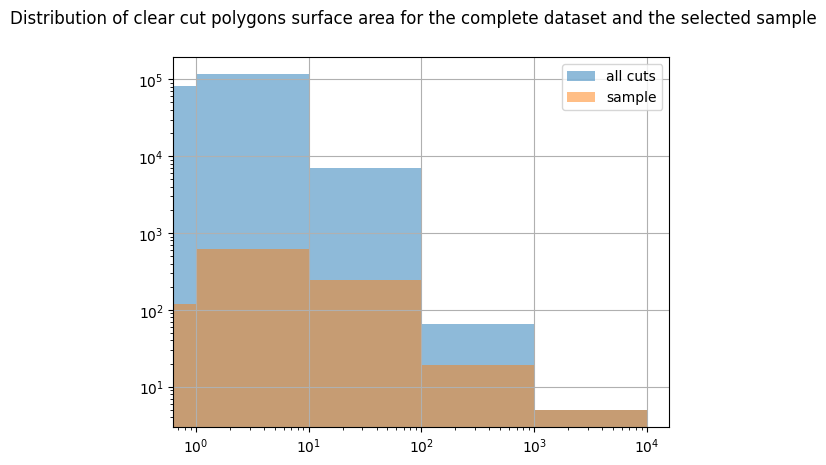

In [67]:
gdf = gpd.read_file("../data/sufosat/sufosat_clear_cuts_v3.fgb")

fig, ax = plt.subplots()
gdf.area_ha.hist(ax=ax, label="all cuts", alpha=0.5, bins=[0, 1, 10, 100, 1000, 10000])
gdf_samp.area_ha.hist(ax=ax, label="sample", alpha=0.5, bins=[0, 1, 10, 100, 1000, 10000])
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
fig.suptitle(
    "Distribution of clear cut polygons surface area for the complete dataset and the selected sample"
)
plt.show()

Unexplained rows with zero cover everywhere and a 'TFV_COMPO' that is a random integer --> filtered (could be wrongly filtered out-of-France polygons?)

In [83]:
all_num_cols = [f"RIA {TFV}" for TFV in plot_palette]
gdf_samp = gdf_samp.drop(gdf_samp.loc[gdf_samp[all_num_cols].max(axis=1) < 0.2].index)

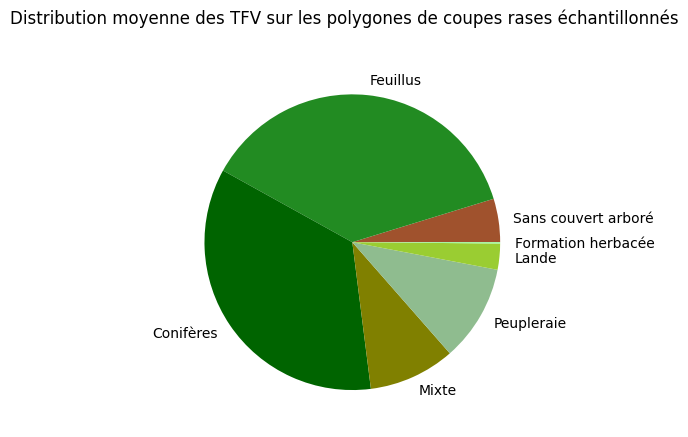

In [116]:
fig, ax = plt.subplots()
all_num_cols = [f"RIA {TFV}" for TFV in plot_palette]
gdf_samp[all_num_cols].mean(axis=0).plot.pie(
    labels=plot_palette.keys(), colors=plot_palette.values()
)
fig.suptitle("Distribution moyenne des TFV sur les polygones de coupes rases échantillonnés")
plt.show()

Nous observons que le TFV dominant sur la plupart des parcelles de coupe rase a une couverture relative typiquement supérieure à 90%, à l'exception des cas de dominance de formations herbacées où la couverture relative est typiquement entre 80% et 90%. Comme ce TFV est fortement minoritaire, nous n'en tiendrons pas compte dans la définition de notre seuil de couverture dominante

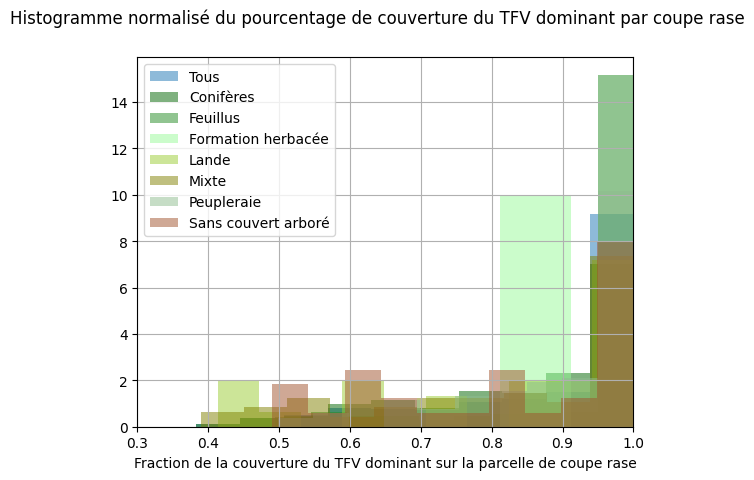

In [101]:
gdf_samp["dominant_TFV"] = gdf_samp[all_num_cols].idxmax(axis=1).str.replace("RIA ", "")

fig, ax = plt.subplots()
gdf_samp[all_num_cols].max(axis=1).hist(label="Tous", alpha=0.5, density=True)
for TFV, group_TFV in gdf_samp.groupby("dominant_TFV"):
    group_TFV[all_num_cols].max(axis=1).hist(
        label=TFV, alpha=0.5, color=plot_palette[TFV], density=True
    )
ax.set_xlim(0.3, 1)
ax.set_xlabel("Fraction de la couverture du TFV dominant sur la parcelle de coupe rase")
ax.legend()
fig.suptitle(
    "Histogramme normalisé du pourcentage de couverture du TFV dominant par coupe rase"
)
plt.show()

In [106]:
dominant_TFV_threshold = 0.75
gdf_dominant_TFV = gdf_samp[(gdf_samp[all_num_cols] > dominant_TFV_threshold).any(axis=1)]
len(gdf_dominant_TFV) / len(gdf_samp)

0.7991543340380549

In [128]:
gdf_dominant_TFV.dominant_TFV.value_counts().loc[list(plot_palette.keys())]

dominant_TFV
Sans couvert arboré     20
Feuillus               295
Conifères              282
Mixte                   53
Peupleraie              88
Lande                   17
Formation herbacée       1
Name: count, dtype: int64

We observe no significant difference between the average and dominant TFV per polygon within the sample clear cuts. We notice however that a small portion of clear cuts have a dominant TFV that is "Sans couvert arboré" which means the clear cut probably predates the Sufosat detection!

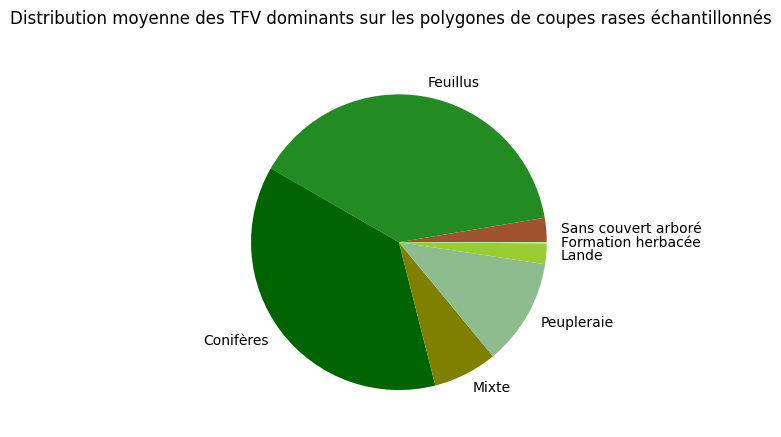

In [129]:
fig, ax = plt.subplots()
gdf_dominant_TFV.dominant_TFV.value_counts().loc[list(plot_palette.keys())].plot.pie(
    labels=plot_palette.keys(), colors=plot_palette.values()
)
ax.set_ylabel("")
fig.suptitle(
    "Distribution moyenne des TFV dominants sur les polygones de coupes rases échantillonnés"
)
plt.show()